---
author: Zeel B Patel
badges: true
categories: ML
description: Non-Gaussian Likelihoods for MLPs
title: Non-Gaussian Likelihoods for MLPs
date: '2023-09-16'
toc: true
---

In [133]:
# %pip install mapie

In [134]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import numpy as np

import torch
import torch.nn as nn
import torch.distributions as dist

from tqdm import tqdm

from sklearn.calibration import calibration_curve
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from mapie.metrics import regression_coverage_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x.shape: torch.Size([100, 1]) y.shape: torch.Size([100, 1])


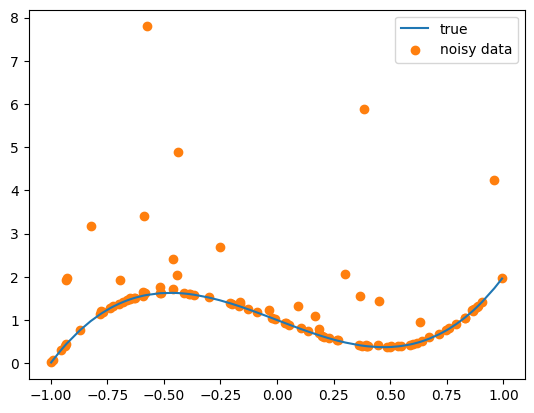

In [135]:
torch.manual_seed(0)

N = 100
x = dist.Uniform(-1, 1).sample((N, 1)).sort(dim=0).values
x_test = torch.linspace(-1, 1, 2 * N).view(-1, 1).sort(dim=0).values
y = 3 * x**3 - 2 * x + 1
y_noisy = y + dist.Gamma(0.1, 0.3).sample((N, 1))

plt.plot(x, y, label="true", color="C0")
plt.scatter(x, y_noisy, label="noisy data", color="C1")

plt.legend()
print("x.shape:", x.shape, "y.shape:", y.shape)


## Define a Gaussian/Gamma MLP

In [175]:
class ProbabilisticMLP(nn.Module):
    def __init__(self, input_dim, feature_dims, type):
        super().__init__()
        self.input_dim = input_dim
        self.feature_dims = feature_dims
        self.type = type  # "gaussian" or "gamma"

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, feature_dims[0]))
        for i in range(len(feature_dims) - 1):
            self.layers.append(nn.Linear(feature_dims[i], feature_dims[i + 1]))
        self.layers.append(nn.Linear(feature_dims[-1], 2))

        # likelihood parameters
        # if self.type == "gaussian":
        #     self.register_buffer("likelihood_mean", torch.zeros(1))
        #     self.likelihood_log_std = nn.Parameter(torch.zeros(1))
        # elif self.type == "gamma":
        #     self.likelihood_log_concentration = nn.Parameter(torch.zeros(1))
        #     self.likelihood_log_rate = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))

        if self.type == "gaussian":
            # y_pred = self.layers[-1](x)
            # likelihood_mean = self.likelihood_mean.expand(y_pred.shape[0])
            # likelihood_log_std = self.likelihood_log_std.expand(y_pred.shape[0])
            # likelihood_std = torch.exp(likelihood_log_std)
            # return y_pred, likelihood_mean, likelihood_std

            y_out = self.layers[-1](x)
            mean = y_out[:, 0]
            log_std = y_out[:, 1]
            std = torch.exp(log_std)
            return mean.ravel(), std.ravel()

        elif self.type == "gamma":
            # y_pred = self.layers[-1](x)
            # likelihood_log_concentration = self.likelihood_log_concentration.expand(
            #     y_pred.shape[0]
            # )
            # likelihood_log_rate = self.likelihood_log_rate.expand(y_pred.shape[0])
            # likelihood_concentration = torch.exp(likelihood_log_concentration)
            # likelihood_rate = torch.exp(likelihood_log_rate)
            # return y_pred, likelihood_concentration, likelihood_rate

            y_out = self.layers[-1](x)
            log_concentration = y_out[:, 0]
            log_rate = y_out[:, 1]
            concentration = torch.exp(log_concentration)
            rate = torch.exp(log_rate)
            return concentration, rate

    def loss_fn(self, y, param1, param2):
        if self.type == "gaussian":
            # epsilon = y - y_pred
            # mean = param1
            # std = param2
            # dist = torch.distributions.Normal(mean, std + 1e-6)
            # return -dist.log_prob(epsilon).mean()
            mean = param1
            std = param2
            dist = torch.distributions.Normal(mean, std + 1e-3)
            return -dist.log_prob(y.ravel()).mean()

        elif self.type == "gamma":
            # epsilon = torch.clip(y - y_pred, min=1e-6, max=1e6)
            # concentration = param1
            # rate = param2
            # dist = torch.distributions.Gamma(concentration, rate)
            # return -dist.log_prob(epsilon).mean()
            concentration = param1
            rate = param2
            dist = torch.distributions.Gamma(concentration + 1e-3, rate + 1e-3)
            return -dist.log_prob(y.ravel()).mean()


## Fit Gaussian MLP

loss: 0.4503: 100%|██████████| 500/500 [00:01<00:00, 291.18it/s]


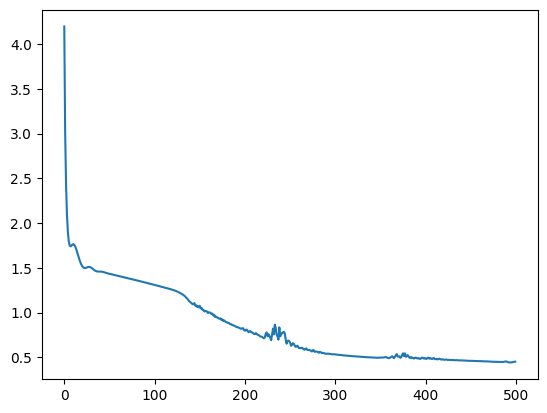

In [176]:
torch.manual_seed(0)

model = ProbabilisticMLP(1, [32, 32], "gaussian").to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
n_epochs = 500

pbar = tqdm(range(n_epochs))
losses = []
for epoch in pbar:
    optimizer.zero_grad()
    param1, param2 = model(x.to(device))
    loss = model.loss_fn(y_noisy.to(device), param1, param2)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    pbar.set_description(f"loss: {loss.item():.4f}")

plt.plot(losses)

In [177]:
# sns.kdeplot(param2.cpu().detach().numpy(), label="std")

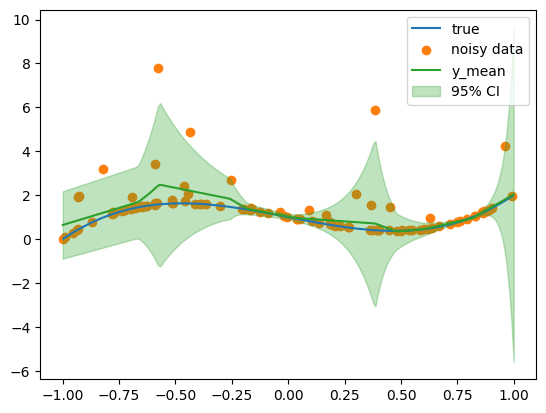

In [178]:
with torch.no_grad():
    y_mean, y_std = model(x_test.to(device))
    y_mean = y_mean.cpu().numpy().ravel()
    y_std = y_std.cpu().numpy().ravel()
    # y_mean = y_pred.cpu().numpy().ravel() + mean.cpu().numpy().ravel()
    # y_std = std.cpu().numpy().ravel()

plt.plot(x, y, label="true", color="C0")
plt.scatter(x, y_noisy, label="noisy data", color="C1")
plt.plot(x_test, y_mean, label="y_mean", color="C2")
plt.fill_between(
    x_test.squeeze(),
    y_mean - 2 * y_std,
    y_mean + 2 * y_std,
    alpha=0.3,
    color="C2",
    label="95% CI",
)

plt.legend()

In [179]:
with torch.no_grad():
    y_mean, y_std = model(x.to(device))
    y_mean = y_mean.cpu().numpy().ravel()
    y_std = y_std.cpu().numpy().ravel()

upper = y_mean + 2 * y_std
lower = y_mean - 2 * y_std

regression_coverage_score(y_noisy.numpy(), lower, upper)

0.91

## Fit Gamma MLP

loss: 0.0775: 100%|██████████| 1000/1000 [00:03<00:00, 266.98it/s]


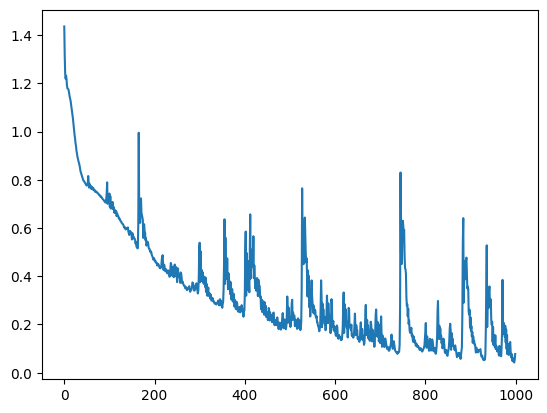

In [180]:
model = ProbabilisticMLP(1, [32, 32, 32], "gamma").to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
n_epochs = 1000

pbar = tqdm(range(n_epochs))
losses = []
for epoch in pbar:
    optimizer.zero_grad()
    param1, param2 = model(x.to(device))
    loss = model.loss_fn(y_noisy.to(device), param1, param2)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    pbar.set_description(f"loss: {loss.item():.4f}")

plt.plot(losses)

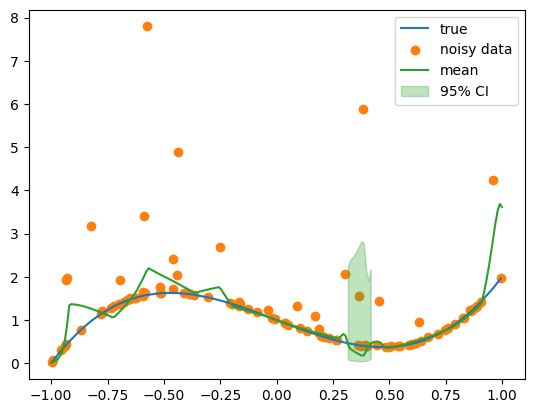

In [181]:
from scipy.special import gammaincinv, gamma

with torch.no_grad():
    concetration, rate = model(x_test.to(device))
    concetration = concetration.cpu().ravel().numpy()
    rate = rate.cpu().ravel().numpy()

    y_mode = (concetration - 1) / rate

    quantile_fn = lambda p: gammaincinv(concetration, gamma(concetration) * p) / rate

    upper = quantile_fn(0.975)
    lower = quantile_fn(0.025)

plt.plot(x, y, label="true", color="C0")
plt.scatter(x, y_noisy, label="noisy data", color="C1")
plt.plot(x_test, y_mode, label="mean", color="C2")
plt.fill_between(
    x_test.squeeze(),
    lower,
    upper,
    alpha=0.3,
    color="C2",
    label="95% CI",
)

plt.legend()

In [182]:
with torch.no_grad():
    param1, param2 = model(x.to(device))
    concetration = param1.cpu().numpy().ravel()
    rate = param2.cpu().numpy().ravel()

    upper = quantile_fn(0.975)
    lower = quantile_fn(0.025)

regression_coverage_score(y_noisy.numpy(), lower, upper)

0.07